In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'    # ignore tensorflow gpu warning

import cv2
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     TimeDistributed, LSTM)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")   # Suppress all warnings

## Hyperparameters

In [2]:
SEED = 123
# BATCH_SIZE = 62
BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)
EPOCHS = 20
CHANNELS = 3  # Color channels (RGB)

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), "dataset")

In [4]:
dataset = image_dataset_from_directory(
  DATASET_PATH,
  seed=SEED,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE
)
categories = dataset.class_names
categories

Found 1097 files belonging to 3 classes.


['Bengin cases', 'Malignant cases', 'Normal cases']

In [5]:
def display_image(_img):
  plt.imshow(_img)
  plt.axis('off')
  plt.show()

In [6]:
def get_all_img_path_list(_path=DATASET_PATH, _categories=categories):
  _result = []
  for i, _category in enumerate(_categories):
    _category_path = os.path.join(_path, _category)
    _files = os.listdir(_category_path)
    for _f in _files:
      _result.append(os.path.join(_category_path, _f))
  return _result

In [7]:
def get_image_sizes(_data_path=DATASET_PATH, _all_categories=categories):
  _size_map = {}
  for _category in _all_categories:
    _path = os.path.join(_data_path, _category)
    _tmp_dict = {}

    for _file in os.listdir(_path):
      img = cv2.imread(os.path.join(_path, _file))
      
      if img is not None:
        _height, _width, _cnl = img.shape
        _sz_key = (_height, _width)
        _tmp_dict[_sz_key] = _tmp_dict.get(_sz_key, 0) + 1

    _size_map[_category] = _tmp_dict
  return _size_map
img_sizes = get_image_sizes()

img_sizes

{'Bengin cases': {(512, 512): 120},
 'Malignant cases': {(512, 623): 31,
  (512, 512): 501,
  (512, 801): 28,
  (404, 511): 1},
 'Normal cases': {(512, 512): 415, (331, 506): 1}}

In [8]:
for _case, _img_size in img_sizes.items():
  print(f"{_case}: ", end="")
  for _size, _count in _img_size.items():
    print(f"{_size[0]}x{_size[1]} ({_count})", end="\n\t\t\t\t\t\t\t\t")
  print("", end="\n")

Bengin cases: 512x512 (120)
								
Malignant cases: 512x623 (31)
								512x512 (501)
								512x801 (28)
								404x511 (1)
								
Normal cases: 512x512 (415)
								331x506 (1)
								


In [9]:
category_counts = {category: np.sum(list(img_sizes[category].values())) for category in categories}

category_counts

{'Bengin cases': 120, 'Malignant cases': 561, 'Normal cases': 416}

In [10]:
category_counts.values()

dict_values([120, 561, 416])

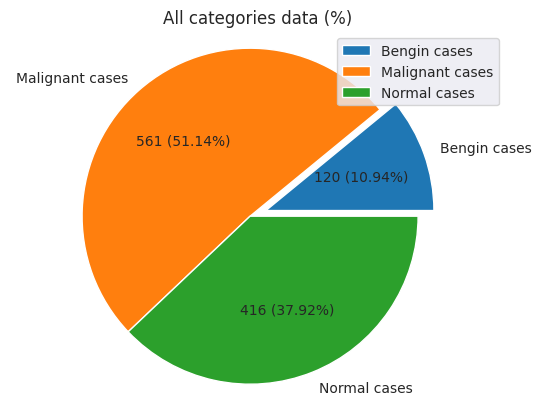

In [29]:
def custom_label(pct):
  total = sum(category_counts.values())
  val = int(round(pct * total / 100.0))
  return f'{val} ({pct:1.2f}%)'

plt.pie(category_counts.values(),
        explode=(0.1, 0, 0),
        # labels=categories, autopct=custom_label)
        labels=categories, autopct=custom_label)

plt.axis('equal')
plt.title('All categories data (%)')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [30]:
category_counts.keys()

dict_keys(['Bengin cases', 'Malignant cases', 'Normal cases'])

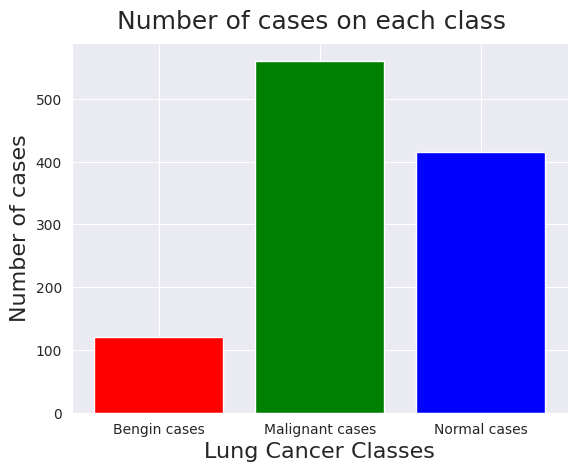

In [31]:
plt.plot(figsize=(10,6))
plt.bar(range(len(categories)), category_counts.values(),
        tick_label=categories, color = ['red', 'green', 'blue'])
plt.suptitle('Number of cases on each class', y=0.95, fontsize=18)
plt.xlabel('Lung Cancer Classes', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.show()

# Visualization

In [11]:
# Sample image shape
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(32, 256, 256, 3)
tf.Tensor(
[[[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 ...

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]

 [[38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]
  ...
  [38. 38. 38.]
  [38. 38. 38.]
  [38. 38. 38.]]], shape=(256, 256, 3), dtype=float32)
[1 0 2 1 0 0 1 1 1 2 0 1 0 1 1 2 2 2 1 1 1 1 1 0 1 1 0 1 1 1 1 2]


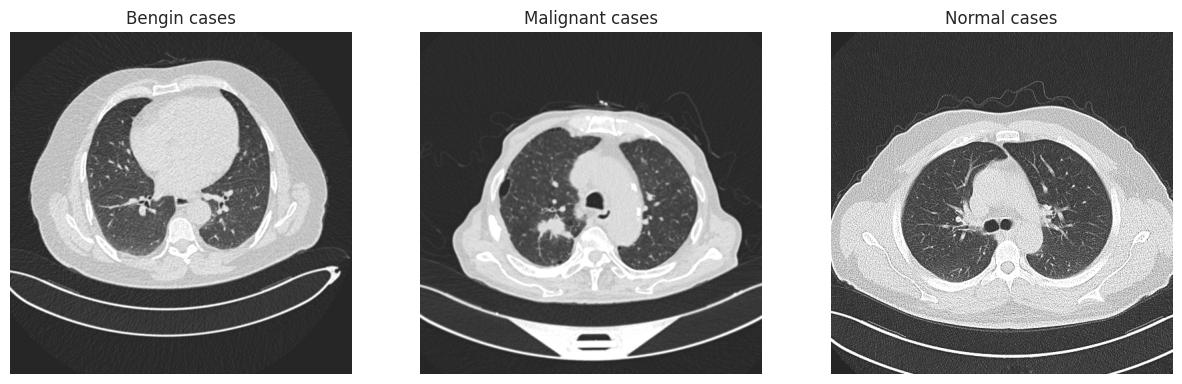

In [32]:
def show_random_img_each_category(_path=DATASET_PATH, _categories=categories):
  _fig, _axes = plt.subplots(1, len(_categories), figsize=(15, 5))
  _image_paths = []
  
  for i, _category in enumerate(_categories):
    _category_path = os.path.join(_path, _category)
    _files = os.listdir(_category_path)
    _rnd_img_index = randint(0, len(_files) - 1)
    _img_path = os.path.join(_category_path, _files[_rnd_img_index])
    
    _img = cv2.imread(_img_path)
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
    _axes[i].imshow(_img)
    _axes[i].axis("off")
    _axes[i].set_title(_category)
    _image_paths.append(_img_path)

  plt.show()
  plt.close()
  return _image_paths

random_images_path = show_random_img_each_category()

In [33]:
random_images_path

['/home/debashis/works/advanced-ML/dataset/Bengin cases/Bengin case (23).jpg',
 '/home/debashis/works/advanced-ML/dataset/Malignant cases/Malignant case (370).jpg',
 '/home/debashis/works/advanced-ML/dataset/Normal cases/Normal case (351).jpg']

In [37]:
min_vals = []
max_vals = []
mean_vals = []
std_devs = []
percentile_25 = []
percentile_50 = []
percentile_75 = []
df_result=[]

for _f in random_images_path:
  _img = cv2.imread(_f, cv2.IMREAD_GRAYSCALE)
  min_val = np.min(_img)
  max_val = np.max(_img)
  mean_val = np.mean(_img)
  std_dev = np.std(_img)
  
  min_vals.append(min_val)
  perc_25 = np.percentile(_img, 25)
  perc_50 = np.percentile(_img, 50)
  perc_75 = np.percentile(_img, 75)
  
  max_vals.append(max_val)
  mean_vals.append(mean_val)
  std_devs.append(std_dev)
  percentile_25.append(perc_25)
  percentile_50.append(perc_50)
  percentile_75.append(perc_75)


In [41]:
df = pd.DataFrame({"mean": mean_vals,
                   "min": min_vals,
                  "std": std_devs,
                   "25%": percentile_25,
                  "50%": percentile_50,
                  "75%": percentile_75,
                 
                 "max": max_vals
                   }).T
df

0           1           2
mean  108.486736   99.490055  120.590656
min    37.000000   37.000000   37.000000
std    76.975175   77.488865   78.346276
25%    43.000000   43.000000   52.000000
50%    60.000000   53.000000   78.000000
75%   197.000000  197.000000  202.000000
max   255.000000  255.000000  255.000000

In [38]:
print("Classes:", )
print("Minimum values:", min_vals)
print("25th percentiles:", percentile_25)
print("50th percentiles:", percentile_50)
print("75th percentiles:", percentile_75)
print("Maximum values:", max_vals)
print("Mean values:", mean_vals)
print("Standard deviations:", std_devs)

Minimum values: [37, 37, 37]
25th percentiles: [43.0, 43.0, 52.0]
50th percentiles: [60.0, 53.0, 78.0]
75th percentiles: [197.0, 197.0, 202.0]
Maximum values: [255, 255, 255]
Mean values: [108.48673629760742, 99.49005508422852, 120.59065628051758]
Standard deviations: [76.97517509780265, 77.48886535577863, 78.34627564015369]


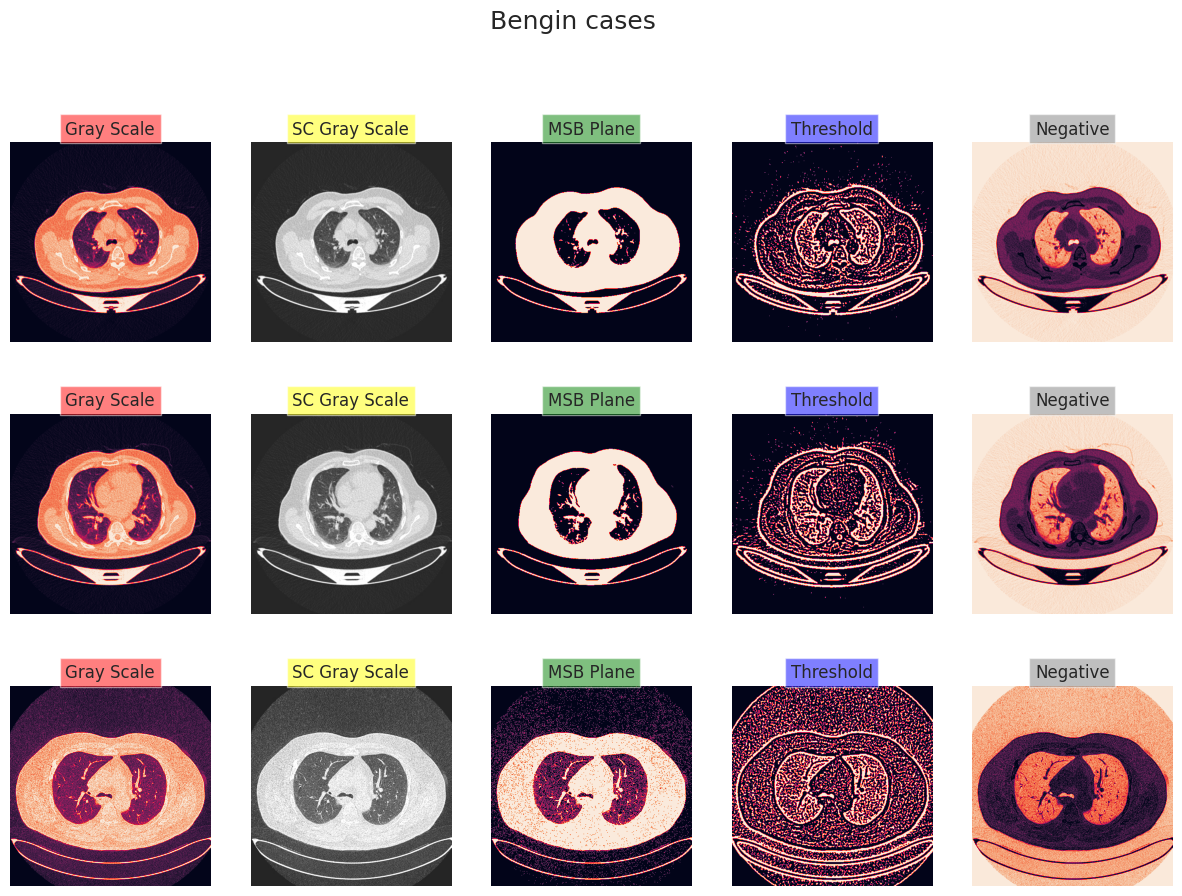

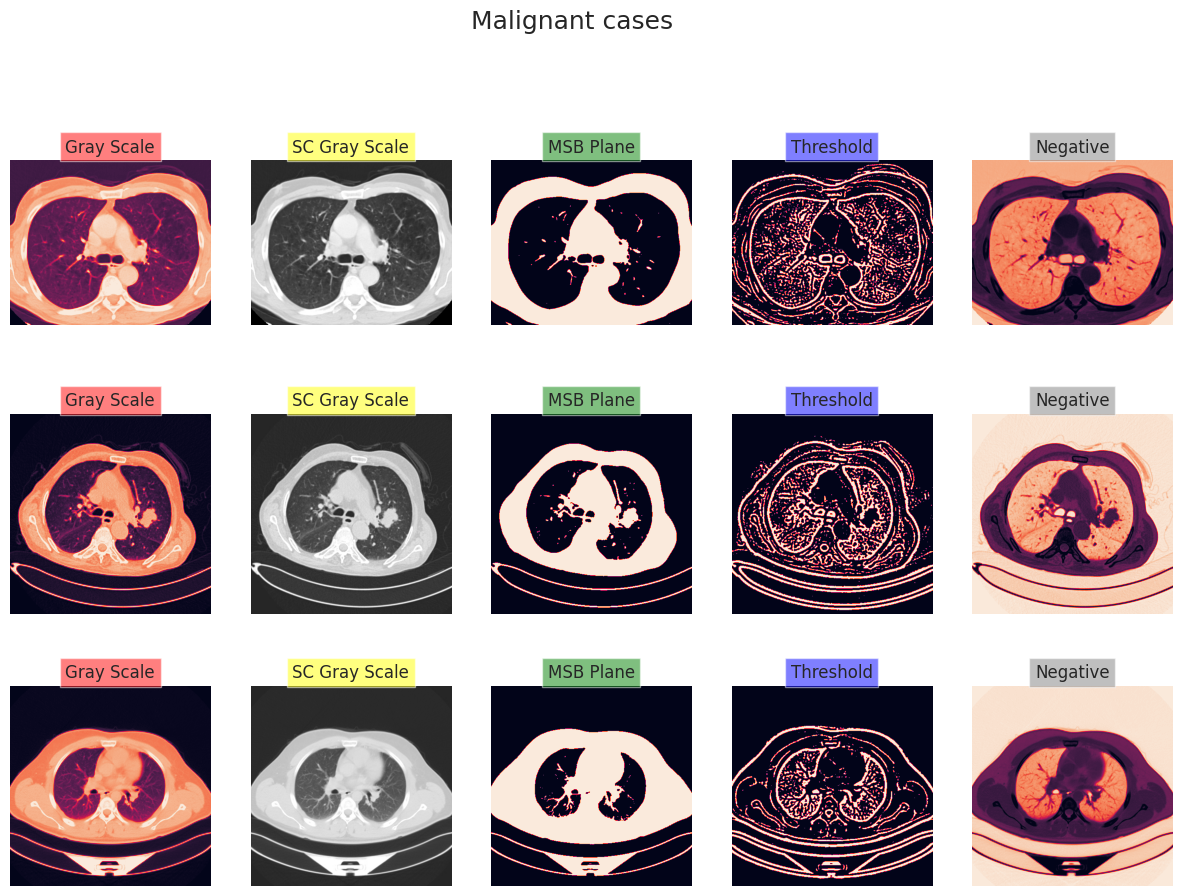

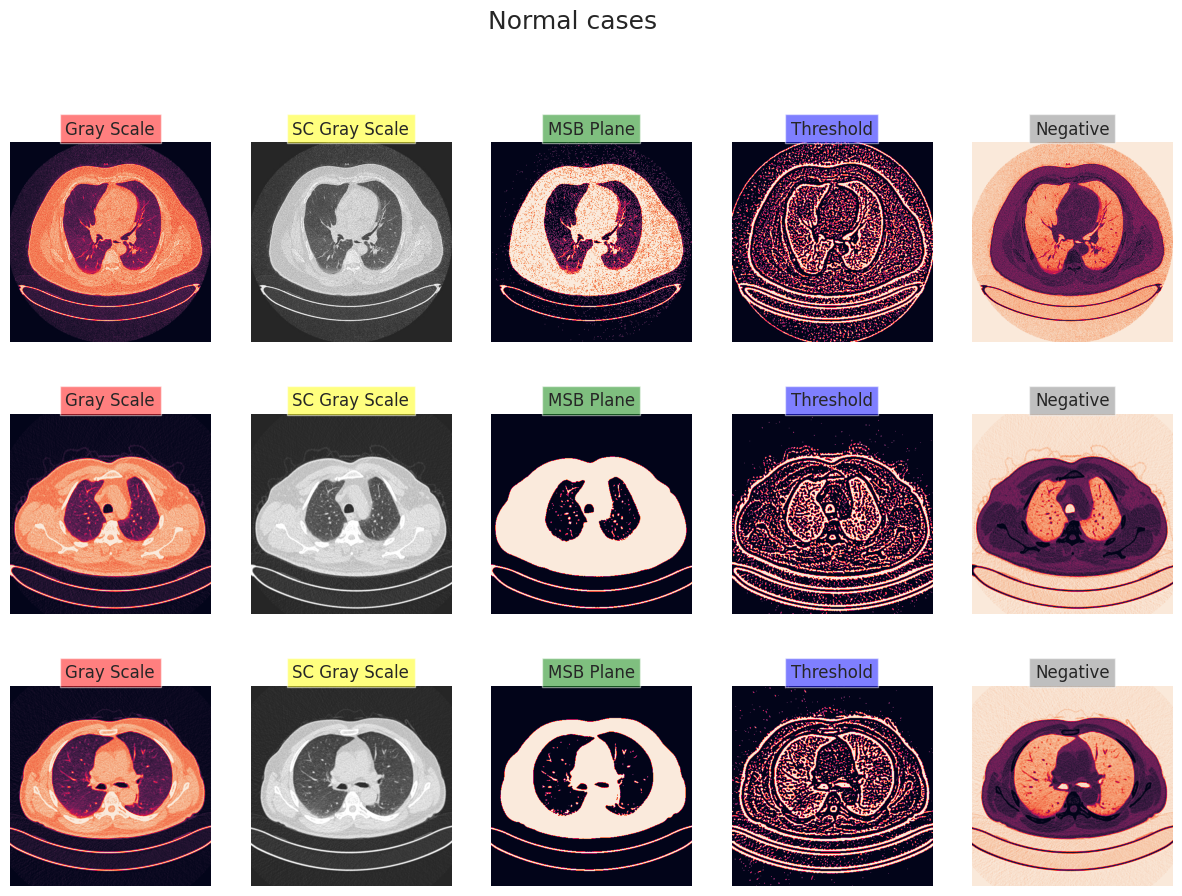

In [74]:
def plot_filtered_images2(_data_path=DATASET_PATH, _categories=categories):
  _filters = ['Gray Scale', 'SC Gray Scale', 'MSB Plane', 'Threshold', 'Negative']
  _filter_colors = ['red', 'yellow', 'green', 'blue', 'gray']
  # Apply the filters on each class of images
  for _category in _categories:
    # Take 3 samples from each class to be processed
    _samples = 3
    _fig, _ax = plt.subplots(_samples, len(_filters), figsize=(15, 10))
    _fig.suptitle(_category, y=1, fontsize=18)

    _path = os.path.join(_data_path, _category)
    
    for idx, _file in enumerate(os.listdir(_path)[:_samples]):
      _img = cv2.imread(os.path.join(_path, _file))
      
      # Apply filters
      _grayscale = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)    # Convert to grayscale
      _gblurred = cv2.GaussianBlur(_grayscale, (5, 5), 0)   # GaussianBlur
      _sc_grayscale = cv2.cvtColor(_img, cv2.IMREAD_GRAYSCALE)

      _filtered_images = (
        # cv2.resize(_img, IMAGE_SIZE), # Resized image
        _grayscale,
        _sc_grayscale,
        cv2.bitwise_and(_grayscale, 0x80),  # Bit Plane Slicing/MSB; width = no. of bits (8 bit img)
        cv2.adaptiveThreshold(_gblurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                              cv2.THRESH_BINARY_INV, 11, 4),   # Adaptive Thresholding
        # cv2.adaptiveThreshold(_gblurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #                       cv2.THRESH_BINARY_INV, 15, 3),   # Adaptive Thresholding
        cv2.bitwise_not(_grayscale)    # Image Negative
      )

      # Display images with titles
      for idx2, (_filtered_img, _title) in enumerate(zip(_filtered_images, _filters)):
        _ax[idx, idx2].imshow(_filtered_img)#, cmap='gray' if idx2 in (0,4) else None)
        _ax[idx, idx2].axis('off')
        _ax[idx, idx2].set_title(_title, bbox=dict(facecolor=_filter_colors[idx2], alpha=0.5))

    plt.show()
    plt.close()
plot_filtered_images2()

In [60]:
# Define the sampling parameters
sample_img=cv2.imread(random_images_path[0])
num_samples = 100  # Number of samples to take
sampled_pixels = []

# Randomly sample pixels from the image
for _ in range(num_samples):
  # Generate random coordinates within the image
  x = np.random.randint(0, sample_img.shape[1])
  y = np.random.randint(0, sample_img.shape[0])
  
  # Get the pixel value at the sampled coordinates
  pixel_value = sample_img[y, x]
  
  # Add the sampled pixel value to the list
  sampled_pixels.append(pixel_value)

# Convert the list of sampled pixels to a NumPy array
sampled_pixels = np.array(sampled_pixels)

# Display the sampled pixels
print("Sampled Pixels:", sampled_pixels)

Sampled Pixels: [[ 48  48  48]
 [ 38  38  38]
 [ 38  38  38]
 [ 38  38  38]
 [225 225 225]
 [203 203 203]
 [ 51  51  51]
 [216 216 216]
 [ 48  48  48]
 [223 223 223]
 [ 38  38  38]
 [ 52  52  52]
 [145 145 145]
 [ 45  45  45]
 [146 146 146]
 [100 100 100]
 [ 47  47  47]
 [ 63  63  63]
 [214 214 214]
 [162 162 162]
 [ 43  43  43]
 [220 220 220]
 [207 207 207]
 [192 192 192]
 [212 212 212]
 [170 170 170]
 [ 38  38  38]
 [ 44  44  44]
 [217 217 217]
 [221 221 221]
 [181 181 181]
 [212 212 212]
 [229 229 229]
 [ 38  38  38]
 [ 41  41  41]
 [189 189 189]
 [188 188 188]
 [ 41  41  41]
 [ 43  43  43]
 [255 255 255]
 [227 227 227]
 [ 47  47  47]
 [187 187 187]
 [ 74  74  74]
 [194 194 194]
 [ 38  38  38]
 [179 179 179]
 [212 212 212]
 [184 184 184]
 [219 219 219]
 [218 218 218]
 [193 193 193]
 [ 42  42  42]
 [204 204 204]
 [193 193 193]
 [ 77  77  77]
 [203 203 203]
 [ 51  51  51]
 [ 50  50  50]
 [ 60  60  60]
 [ 52  52  52]
 [200 200 200]
 [204 204 204]
 [ 40  40  40]
 [203 203 203]
 [ 84  84

# Model Training

In [11]:
images = []
labels = []
for image_batch, label_batch in dataset:
  images.extend(image_batch.numpy())
  labels.extend(label_batch.numpy())

In [12]:
X = np.array(images)
y = np.array(labels)

In [13]:
X.shape

(1097, 256, 256, 3)

In [14]:
y = to_categorical(y, num_classes=CHANNELS)
y.shape

(1097, 3)

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
_train, _test, validation_train, validation_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [16]:
X_train.shape

(877, 256, 256, 3)

# Normalize

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
def _CNN_model_compile(_input_shape):
  _cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=_input_shape),
    MaxPooling2D((2, 2)),
  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
  
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(CHANNELS, activation='softmax')
  ])
  
  _cnn.build(input_shape=input_shape)

  _cnn.compile(optimizer='adam',
               # loss='sparse_categorical_crossentropy',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
  
  return _cnn

def _print_loss_accuracy(_model, _X_test, _y_test, title):
  _loss, _accuracy = _model.evaluate(_X_test, _y_test, verbose=2)
  print(f'{title} => Loss: {_loss}, Accuracy: {_accuracy}')

In [19]:
input_shape = (*IMAGE_SIZE, CHANNELS)

In [20]:
model_cnn = _CNN_model_compile(input_shape)

history_cnn = model_cnn.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 8s 251ms/step - loss: 1.0102 - accuracy: 0.4515 - val_loss: 0.9764 - val_accuracy: 0.4682
Epoch 2/20
28/28 [==============================] - 7s 252ms/step - loss: 0.9176 - accuracy: 0.5690 - val_loss: 0.8451 - val_accuracy: 0.5909
Epoch 3/20
28/28 [==============================] - 7s 247ms/step - loss: 0.7822 - accuracy: 0.6727 - val_loss: 0.7621 - val_accuracy: 0.7136
Epoch 4/20
28/28 [==============================] - 7s 243ms/step - loss: 0.6745 - accuracy: 0.7172 - val_loss: 0.5868 - val_accuracy: 0.7727
Epoch 5/20
28/28 [==============================] - 7s 237ms/step - loss: 0.5241 - accuracy: 0.7891 - val_loss: 0.4486 - val_accuracy: 0.8273
Epoch 6/20
28/28 [==============================] - 7s 245ms/step - loss: 0.3693 - accuracy: 0.8540 - val_loss: 0.3888 - val_accuracy: 0.8318
Epoch 7/20
28/28 [==============================] - 7s 244ms/step - loss: 0.2681 - accuracy: 0.8894 - val_loss: 0.2259 - val_accuracy: 0.9182
Epoch 

In [21]:
_print_loss_accuracy(model_cnn, X_test, y_test, "CNN")

7/7 - 1s - loss: 0.0457 - accuracy: 0.9773 - 531ms/epoch - 76ms/step
CNN => Loss: 0.04572160169482231, Accuracy: 0.9772727489471436


# Accuracy & Error graph

In [25]:
def acc_err_plot(history):
  fig, axs = plt.subplots(2)

  # create accuracy sublpot
  axs[0].plot(history.history["accuracy"], label="train accuracy")
  axs[0].plot(history.history["val_accuracy"], label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")
  
  # create error sublpot
  axs[1].plot(history.history["loss"], label="train error")
  axs[1].plot(history.history["val_loss"], label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")
  
  plt.tight_layout()
  plt.show()
  plt.close()

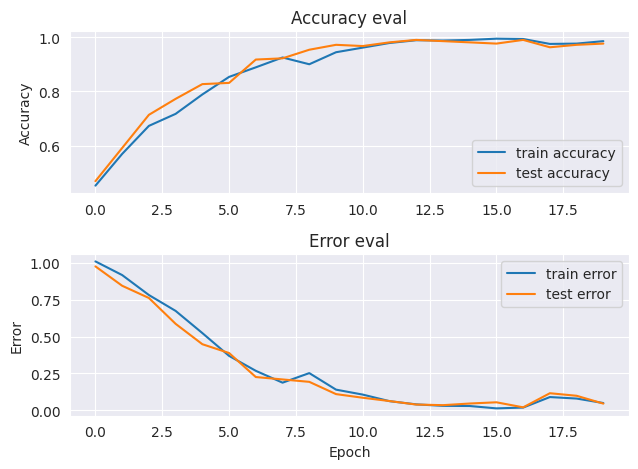

In [26]:
acc_err_plot(history_cnn)

# Augmentation

In [22]:
datagen = ImageDataGenerator(
  width_shift_range=0.1,  # Shift images horizontally by 10%
  zoom_range=0.15,  # Zoom 15%
)
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [23]:
model_cnn2 = _CNN_model_compile(input_shape)

In [24]:
history_cnn2 = model_cnn2.fit(train_generator,
                        validation_data=(X_test, y_test),
                        batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 11s 357ms/step - loss: 0.9796 - accuracy: 0.4960 - val_loss: 0.9678 - val_accuracy: 0.4682
Epoch 2/20
28/28 [==============================] - 10s 346ms/step - loss: 0.9313 - accuracy: 0.5439 - val_loss: 0.9186 - val_accuracy: 0.4682
Epoch 3/20
28/28 [==============================] - 10s 347ms/step - loss: 0.8449 - accuracy: 0.6203 - val_loss: 0.8152 - val_accuracy: 0.7182
Epoch 4/20
28/28 [==============================] - 10s 337ms/step - loss: 0.8046 - accuracy: 0.6579 - val_loss: 0.7303 - val_accuracy: 0.7318
Epoch 5/20
28/28 [==============================] - 10s 342ms/step - loss: 0.7713 - accuracy: 0.6819 - val_loss: 0.6532 - val_accuracy: 0.7682
Epoch 6/20
28/28 [==============================] - 10s 342ms/step - loss: 0.7042 - accuracy: 0.7309 - val_loss: 0.6339 - val_accuracy: 0.7409
Epoch 7/20
28/28 [==============================] - 10s 344ms/step - loss: 0.6871 - accuracy: 0.7241 - val_loss: 0.6213 - val_accuracy: 0.7818

In [146]:
_print_loss_accuracy(model_cnn2, X_test, y_test, "CNN")

7/7 - 1s - loss: 0.2491 - accuracy: 0.9182 - 634ms/epoch - 91ms/step
CNN => Loss: 0.24907127022743225, Accuracy: 0.918181836605072


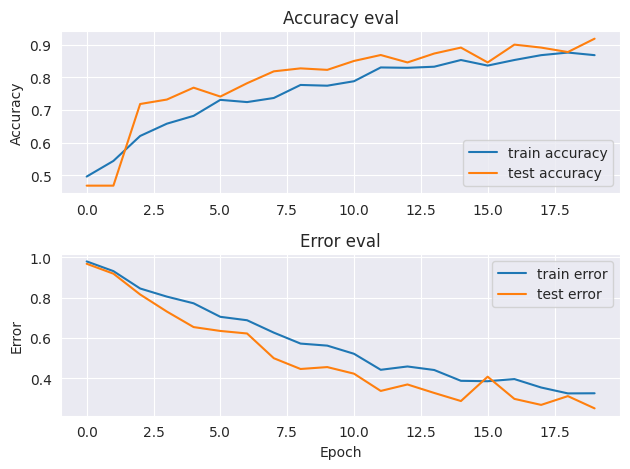

In [147]:
acc_err_plot(history_cnn2)

In [42]:
dataset_grayscale = image_dataset_from_directory(
  DATASET_PATH,
  seed=SEED,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  color_mode='grayscale'
)

images_gs = []
labels_gs = []
for image_batch_gs, label_batch_gs in dataset_grayscale:
  images_gs.extend(image_batch_gs.numpy())
  labels_gs.extend(label_batch_gs.numpy())

X_gs = np.array(images_gs)
y_gs = np.array(labels_gs)

y_gs = to_categorical(y_gs, num_classes=CHANNELS)

X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(
  X_gs, y_gs, test_size=0.2, random_state=SEED)

X_train_gs = X_train_gs / 255.0
X_test_gs = X_test_gs / 255.0


Found 1097 files belonging to 3 classes.


In [32]:
X_gs.shape

(1097, 256, 256, 1)

In [41]:
y_gs.shape

(1097,)

In [36]:
model_cnn_gs = _CNN_model_compile(X_train_gs.shape[1:])

history_cnn_gs = model_cnn_gs.fit(X_train_gs, y_train_gs,
                            validation_data=(X_test_gs, y_test_gs),
                            batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 8s 260ms/step - loss: 0.9637 - accuracy: 0.5188 - val_loss: 0.9715 - val_accuracy: 0.4682
Epoch 2/20
28/28 [==============================] - 7s 263ms/step - loss: 0.8929 - accuracy: 0.5827 - val_loss: 0.8087 - val_accuracy: 0.6591
Epoch 3/20
28/28 [==============================] - 7s 265ms/step - loss: 0.7844 - accuracy: 0.6750 - val_loss: 0.7840 - val_accuracy: 0.6182
Epoch 4/20
28/28 [==============================] - 7s 250ms/step - loss: 0.6383 - accuracy: 0.7355 - val_loss: 0.4959 - val_accuracy: 0.8045
Epoch 5/20
28/28 [==============================] - 7s 256ms/step - loss: 0.4557 - accuracy: 0.8119 - val_loss: 0.4230 - val_accuracy: 0.8091
Epoch 6/20
28/28 [==============================] - 7s 250ms/step - loss: 0.3743 - accuracy: 0.8518 - val_loss: 0.3070 - val_accuracy: 0.8773
Epoch 7/20
28/28 [==============================] - 7s 249ms/step - loss: 0.2610 - accuracy: 0.8894 - val_loss: 0.2145 - val_accuracy: 0.8955
Epoch 

In [149]:
_print_loss_accuracy(model_cnn_gs, X_test_gs, y_test_gs, "CNN")

7/7 - 1s - loss: 0.0932 - accuracy: 0.9818 - 548ms/epoch - 78ms/step
CNN => Loss: 0.09315353631973267, Accuracy: 0.9818181991577148


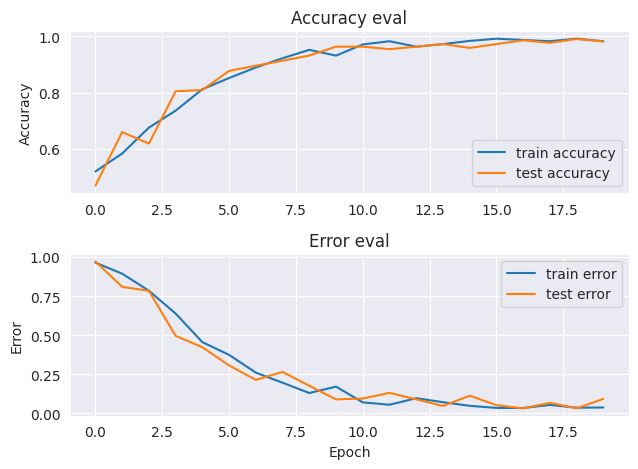

In [150]:
acc_err_plot(history_cnn_gs)

In [47]:
datagen2 = ImageDataGenerator(
  width_shift_range=0.1,  # Shift images horizontally by 10%
  zoom_range=0.15,  # Zoom 15%
)

train_generator_gs = datagen2.flow(X_train_gs, y_train_gs, batch_size=BATCH_SIZE)

model_cnn_gs2 = _CNN_model_compile(X_train_gs.shape[1:])

history_cnn_gs2 = model_cnn_gs2.fit(train_generator_gs,
                            validation_data=(X_test_gs, y_test_gs),
                            batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 8s 266ms/step - loss: 0.9794 - accuracy: 0.4914 - val_loss: 0.9688 - val_accuracy: 0.4682
Epoch 2/20
28/28 [==============================] - 8s 274ms/step - loss: 0.9557 - accuracy: 0.5188 - val_loss: 0.9533 - val_accuracy: 0.4682
Epoch 3/20
28/28 [==============================] - 7s 264ms/step - loss: 0.8908 - accuracy: 0.5804 - val_loss: 0.8191 - val_accuracy: 0.6682
Epoch 4/20
28/28 [==============================] - 7s 258ms/step - loss: 0.8004 - accuracy: 0.6705 - val_loss: 0.7443 - val_accuracy: 0.7182
Epoch 5/20
28/28 [==============================] - 7s 261ms/step - loss: 0.7916 - accuracy: 0.6716 - val_loss: 0.7105 - val_accuracy: 0.7182
Epoch 6/20
28/28 [==============================] - 7s 258ms/step - loss: 0.7212 - accuracy: 0.7047 - val_loss: 0.6433 - val_accuracy: 0.7591
Epoch 7/20
28/28 [==============================] - 7s 265ms/step - loss: 0.6921 - accuracy: 0.7218 - val_loss: 0.6451 - val_accuracy: 0.7318
Epoch 

In [151]:
_print_loss_accuracy(model_cnn_gs2, X_test_gs, y_test_gs, "CNN")

7/7 - 1s - loss: 0.3875 - accuracy: 0.8591 - 579ms/epoch - 83ms/step
CNN => Loss: 0.3874666690826416, Accuracy: 0.8590909242630005


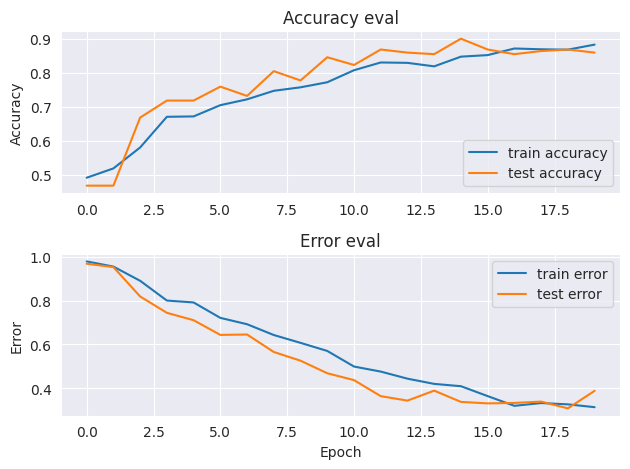

In [50]:
acc_err_plot(history_cnn_gs2)

In [100]:
def _LSTM_model_compile(_input_shape):
  _lstm = Sequential([
    TimeDistributed(Flatten(), input_shape=input_shape),
    LSTM(32, return_sequences=True),
    LSTM(64),
    
    Dense(64, activation='relu'),
    
    Dense(64, activation='relu'),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(CHANNELS, activation='softmax')
  ])
  
  _lstm.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return _lstm

In [101]:
model_lstm = _LSTM_model_compile((X_train.shape[1:],))
history_lstm = model_lstm.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 6s 134ms/step - loss: 0.9982 - accuracy: 0.4892 - val_loss: 0.9692 - val_accuracy: 0.4682
Epoch 2/20
28/28 [==============================] - 3s 119ms/step - loss: 0.9375 - accuracy: 0.5097 - val_loss: 0.9903 - val_accuracy: 0.4682
Epoch 3/20
28/28 [==============================] - 3s 118ms/step - loss: 0.9352 - accuracy: 0.5097 - val_loss: 0.9538 - val_accuracy: 0.4682
Epoch 4/20
28/28 [==============================] - 3s 114ms/step - loss: 0.8994 - accuracy: 0.5348 - val_loss: 1.0506 - val_accuracy: 0.3773
Epoch 5/20
28/28 [==============================] - 4s 141ms/step - loss: 0.8589 - accuracy: 0.5439 - val_loss: 0.9374 - val_accuracy: 0.4545
Epoch 6/20
28/28 [==============================] - 3s 118ms/step - loss: 0.8473 - accuracy: 0.5895 - val_loss: 0.9457 - val_accuracy: 0.4818
Epoch 7/20
28/28 [==============================] - 3s 114ms/step - loss: 0.8146 - accuracy: 0.5998 - val_loss: 0.8701 - val_accuracy: 0.5591
Epoch 

In [102]:
_print_loss_accuracy(model_lstm, X_test, y_test, "LSTM")

7/7 - 0s - loss: 0.6168 - accuracy: 0.7591 - 224ms/epoch - 32ms/step
LSTM => Loss: 0.6167806386947632, Accuracy: 0.7590909004211426


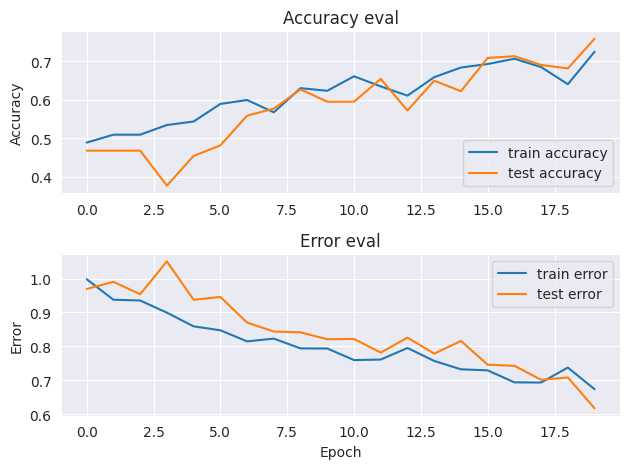

In [105]:
acc_err_plot(history_lstm)

In [104]:
model_lstm2 = _LSTM_model_compile((X_train.shape[1:],))
history_lstm2 = model_lstm.fit(train_generator,
                              validation_data=(X_test, y_test),
                              batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
28/28 [==============================] - 10s 314ms/step - loss: 0.9581 - accuracy: 0.5439 - val_loss: 0.9569 - val_accuracy: 0.4364
Epoch 2/20
28/28 [==============================] - 5s 183ms/step - loss: 0.9093 - accuracy: 0.5302 - val_loss: 0.8855 - val_accuracy: 0.5500
Epoch 3/20
28/28 [==============================] - 5s 182ms/step - loss: 0.8523 - accuracy: 0.5929 - val_loss: 0.8844 - val_accuracy: 0.5591
Epoch 4/20
28/28 [==============================] - 5s 187ms/step - loss: 0.8727 - accuracy: 0.5724 - val_loss: 0.9320 - val_accuracy: 0.5818
Epoch 5/20
28/28 [==============================] - 5s 179ms/step - loss: 0.8843 - accuracy: 0.5382 - val_loss: 0.8948 - val_accuracy: 0.5182
Epoch 6/20
28/28 [==============================] - 5s 175ms/step - loss: 0.8762 - accuracy: 0.5553 - val_loss: 0.8983 - val_accuracy: 0.5909
Epoch 7/20
28/28 [==============================] - 5s 186ms/step - loss: 0.8444 - accuracy: 0.5906 - val_loss: 0.8335 - val_accuracy: 0.6000
Epoch

In [130]:
_print_loss_accuracy(model_lstm2, X_test, y_test, "LSTM")

7/7 - 0s - loss: 1.1008 - accuracy: 0.1364 - 256ms/epoch - 37ms/step
LSTM => Loss: 1.1007652282714844, Accuracy: 0.13636364042758942


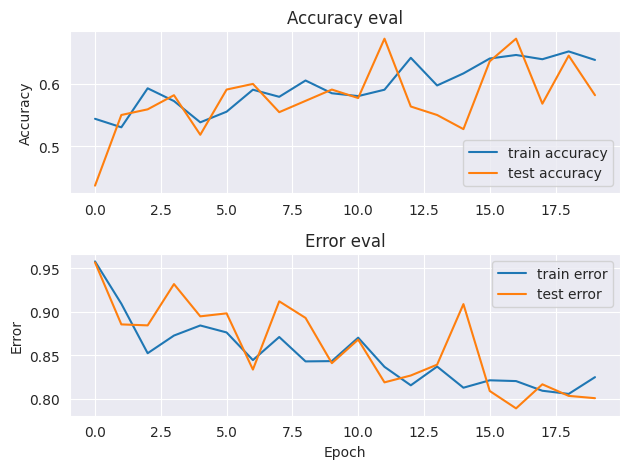

In [131]:
acc_err_plot(history_lstm2)

In [126]:
X_train_gs_reshaped = X_train_gs.reshape(X_train_gs.shape[0], *IMAGE_SIZE)
X_test_gs_reshaped = X_test_gs.reshape(X_test_gs.shape[0], *IMAGE_SIZE)

In [127]:
X_train_gs_reshaped.shape

(877, 256, 256)

In [ ]:
model_lstm_gs = Sequential([
    # LSTM(32, input_shape=IMAGE_SIZE),
  Conv2D(32, (3, 3), activation='relu', input_shape=(256,256,1)),
    LSTM(64),
    
    Dense(64, activation='relu'),
    
    Dense(64, activation='relu'),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='softmax')
  ])
  
model_lstm_gs.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history_lstm_gs = model_lstm.fit(X_train_gs, y_train_gs,
                                 validation_data=(X_test_gs_reshaped, y_test_gs),
                                 batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
_print_loss_accuracy(model_lstm2, X_test, y_test, "LSTM")

In [ ]:
model_lstm_gs2 = _LSTM_model_compile((X_train_gs.shape[1:],))
history_lstm_gs2 = model_lstm.fit(train_generator,
                              validation_data=(X_test_gs, y_test_gs),
                              batch_size=BATCH_SIZE, epochs=EPOCHS)

# Performance metrics

In [158]:
y_test_gs[0]

array([0., 1., 0.], dtype=float32)

In [159]:
from sklearn.metrics import classification_report

In [165]:
y_pred_a = model_cnn_gs.predict(X_test_gs)
y_pred = np.argmax(y_pred_a, axis=1)

y_test_categorical = np.argmax(y_test, axis=1)
print(classification_report(y_test_categorical, y_pred))

7/7 [==============================] - 1s 77ms/step
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        26
           1       0.99      1.00      1.00       103
           2       0.97      1.00      0.98        91

    accuracy                           0.98       220
   macro avg       0.99      0.95      0.97       220
weighted avg       0.98      0.98      0.98       220


In [166]:
import seaborn as sns

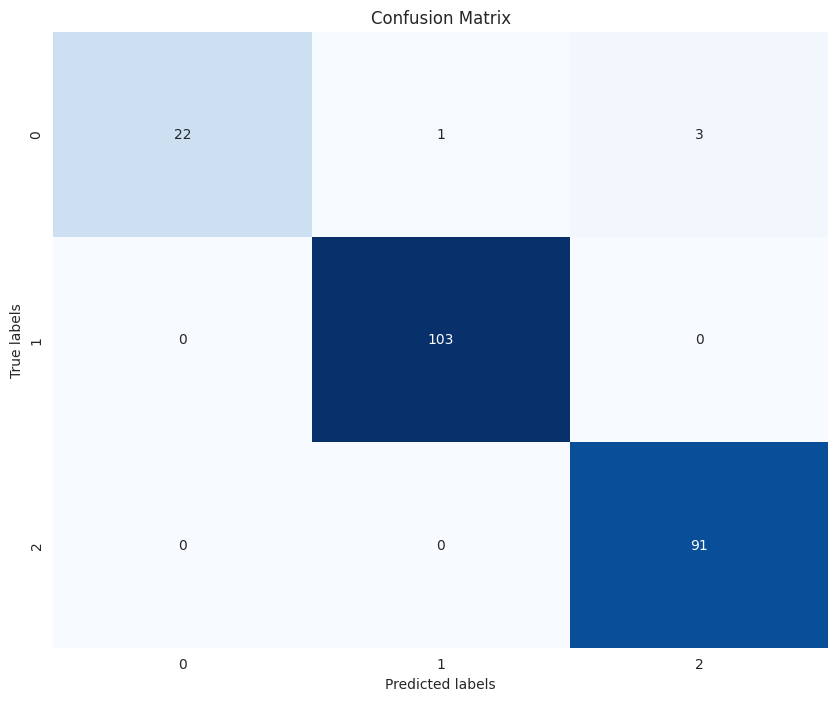

In [167]:
cm = confusion_matrix(y_test_categorical, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [168]:
TP = cm.diagonal()
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)

for i in range(len(TP)):
  print(f"Class {i}: TP={TP[i]}, FP={FP[i]}, TN={TN[i]}, FN={FN[i]}")

Class 0: TP=22, FP=0, TN=194, FN=4
Class 1: TP=103, FP=1, TN=116, FN=0
Class 2: TP=91, FP=3, TN=126, FN=0
